In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from stockmarket import Market, Stock, Investor

In [4]:
sectors = {
    10: {"name": "Energy", "weight": .09, "cagr": .02, "sentiment": .1},
    15: {"name": "Materials", "weight": .09, "cagr": .02, "sentiment": .1},
    20: {"name": "Industrials", "weight": .09, "cagr": .02, "sentiment": .1},
    25: {"name": "Consumer Discretionary", "weight": .09, "cagr": .02, "sentiment": .1},
    30: {"name": "Consumer Staples", "weight": .09, "cagr": .02, "sentiment": .1},
    35: {"name": "Healthcare", "weight": .09, "cagr": .02, "sentiment": .1},
    40: {"name": "Financials", "weight": .09, "cagr": .02, "sentiment": .1},
    45: {"name": "Information Technology", "weight": .1, "cagr": .02, "sentiment": .1},
    50: {"name": "Communication Services", "weight": .09, "cagr": .02, "sentiment": .1},
    55: {"name": "Utilities", "weight": .09, "cagr": .02, "sentiment": .1},
    60: {"name": "Real Estate", "weight": .09, "cagr": .02, "sentiment": .1}
}

In [5]:
markets = { 
    1: {'name': 'US', "weight": .2, "cagr": .3, "sentiment": .1},
    2: {'name': 'Europe', "weight": .16, "cagr": .3, "sentiment": .1},
    3: {'name': 'South America', "weight": .16, "cagr": .3, "sentiment": .1},
    4: {'name': 'China', "weight": .16, "cagr": .3, "sentiment": .1},
    5: {'name': 'Oceania', "weight": .16, "cagr": .3, "sentiment": .1},
    6: {'name': 'Asia', "weight": .16, "cagr": .3, "sentiment": .1}
}

### Average Perceived Value

The *average perceived value* models be the value of the stock in a perfectly efficient market. We'll see what the trading price behaves like, when we expose this stock to a bunch of momentum investors...;-)

In our playground, a year has three equally long quarters of 90 days each. Every day is a trading day.

In the context of this playground, we define the *average perceived value* of an equity by:

$$
\psi(t) = \psi_0 e^{\frac{1}{2}\frac{t}{360} \nu \cdot (1+\phi(t))}
$$

where t is the time measured in days from the beginning of the experiment, $\Psi_0$ is the initial *average perceived value*, $\nu$ is the growth exponent defined with the help of the expected compound annual growth rate $\mathbb{E}(cagr)$

$$
\nu = ln(1+\mathbb{E}(cagr))
$$ 

and $\phi(t): \mathbb{N}^+ \rightarrow [-\infty, 1]$ is the piece-wise linear, (potentially) non-continuous sentiment over time of the trading community with regards to the given equity.

A neutral sentiment of $\phi(t)=0$ over the entire period would mean that it is maximum likely to meet its expected $cagr$. Obviously, a negative sentiment will cause the stock value to decline over time. We allow it do decline arbitrarily rapidly by allowing $\phi$ to yield very large negative values. 

Let's look at a ficticious example of a growth stock over the course of 2 years missing a few of its quarterly earning targets, but winning back trust again and again

In [6]:
class Trending:
    def __init__(self, name, sentiments):
        """
        Parameters:
        sentiments: A map {t_i: (a_i, b_i)} that defines the discontinuous piecewise
        linear sentiment function. See implementation of phi(t) to understand.
        """
        self.name = name
        self.sentiments = sentiments
        
    def phi(self, t):
        periods = sorted(self.sentiments.items())
        current_period = 0
        for p in periods:
            if p[0] > t: 
                break
            else:
                current_period = p
        t0, (alpha, beta) = current_period
        return alpha + (t-t0) * beta

In [7]:
class Stock(Trending):
    def __init__(self, name, psi0, E_cagr, sentiments, 
                 noise, segments={}, markets={}):
        """
        Parameters: 
        psi0: the initial average perceived value of the stock
        E_cagr: the expacted compound annual growth rate for constant neutral sentiment
        sentiments: A map of periods - see class Trending
        segments: map of segments as keys and their weights (adding up to 1.0)
        """
        super(Stock, self).__init__(name, sentiments)
        self.psi0 = psi0
        self.nu = nu = np.log(1+E_cagr)
        self.noise = noise
        self.segments = segments
        self.markets = markets
        
    def value(self, t):
        return np.random.normal(self.psi(t), self.noise)
        
    def psi(self,t):
        """
        the total sentiment score from all geomarket exposures and segments
        """
        sent = self.phi(t) + (
            np.sum([s[1] * s[0].phi(t) for s in self.segments.items()]) +
            np.sum([m[1] * m[0].phi(t) for m in self.markets.items()]))
        return self.psi0 * np.exp(t/360*self.nu*(1+sent))
        

In [8]:
class GeoMarket(Trending):
    def __init__(self, name, sentiments):
        super(GeoMarket, self).__init__(name, sentiments)
        
class Segment(Trending):
    def __init__(self, name, sentiments):
        super(Segment, self).__init__(name, sentiments)
    

In [9]:
## Geo markets

# A bullish year followed by a bearish one
us = GeoMarket('US', {0: (.1,0), 360: (-.6, 0)})
# Obviously, the trade war is ongoing
china = GeoMarket('China', {0: (-.1,0), 360: (.2, 0)})
# Europe is stable
europe = GeoMarket('Europe', {0: (.2,0), 360: (.2, 0)})



## Segments

# IT has come to a saturation and disappointment phase
it = Segment('Information Technology', {0: (-.1, 0)})
# Industry
industrials = Segment('Industrials', {0: (-.1, 0)})


We model stock sentiment as a function that changes quarterly

In [10]:
aapl_sentiments = {
    0: (1, 0),         # start bullish for the first 90 days 
    90: (.5, .5/90),   # cool down a bit but recover well
    180: (-1, 1/90),   # bad earnings, still recovering well
    360: (.4, 0),      # good sentiment
    450: (.3, 0),
    540: (.6, 0),
    630: (0, -1/180),
    720: (0, 0)}  # initially neutral sentiment - decreasing

msft_sentiments = {
    0: (.1, 0),       
    90: (.2, .5/90),  
    180: (.1, 1/90),  
    360: (-.1, 0),    
    450: (.2, 0),
    540: (.1, 0),
    630: (0, -1/180),
    720: (0, 0)}  

tsla_sentiments = {
    0: (.1, 0),       
    90: (-.2, .1/90),  
    180: (.1, -1/90),  
    360: (-.1, 0),    
    450: (.2, 0),
    540: (-.1, 0),
    630: (0, -1/180),
    720: (0, 0)}  

In [11]:
aapl = Stock(name='AAPL', psi0=100, E_cagr=0.05, 
             segments = {it: 1.0}, 
             markets={us: 0.5, europe: .3, china: 0.2},
             sentiments=aapl_sentiments, noise=2.0)

msft = Stock(name='MSFT', psi0=200, E_cagr=0.03, 
             segments = {it: 1.0}, 
             markets={us: .5, europe: .4, china: .1},
             sentiments=msft_sentiments, noise=2.0)

tsla = Stock(name='TSLA', psi0=150, E_cagr=0.06, 
             segments = {industrials: 1.0}, 
             markets={us: .4, europe: .6, china: 0},
             sentiments=tsla_sentiments, noise=2.0)


### The sentiment over time

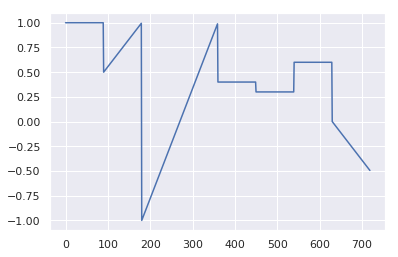

In [12]:
sns.set(rc={'figure.figsize':(6.0,4.0)})
period = np.arange(720)
sns.lineplot(period, [aapl.phi(t) for t in period]);

### The expected *perceived value*

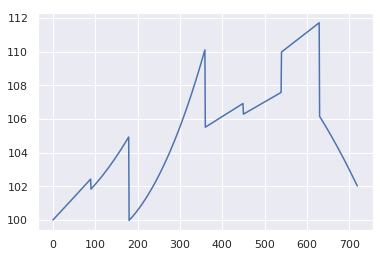

In [13]:
sns.set(rc={'figure.figsize':(6.0,4.0)})
period = np.arange(720)
sns.lineplot(period, [aapl.psi(t) for t in period]);

In [14]:
market = Market(stocks=[aapl, msft, tsla], bid_ask=0.1)

In [15]:
market.open()
market.price_for('AAPL')

(100.963, 100.763)

In [16]:
NUM_INVESTORS = 10
NUM_DAYS = 720
NUM_ROUNDS_PER_DAY = 3

### Investors

In [17]:
from investors import MomentumInvestor

In [18]:
investors = []
for i in range(NUM_INVESTORS):
    wr, wm, span = 0.3, 0.1, 40
    portfolio =  {'AAPL': 500, 'TSLA': 500, 'MSFT': 500}
    investor = MomentumInvestor("m-%s" % i, 1e5, portfolio, wr, wm, span)
    investors.append(investor)

#### Some trading days

In [19]:
dailies = []
market.close()
for day in range(NUM_DAYS):
    market.open()
    for _ in range(NUM_ROUNDS_PER_DAY):
        for investor in investors:
            investor.act(market)
    daily = market.close()

## Inertia
In the below plot, you can see the effect of the inertia created by the (uninformed) momentum investors: Here - and sometimes in the real world - inertia exists only because people believe it exists.

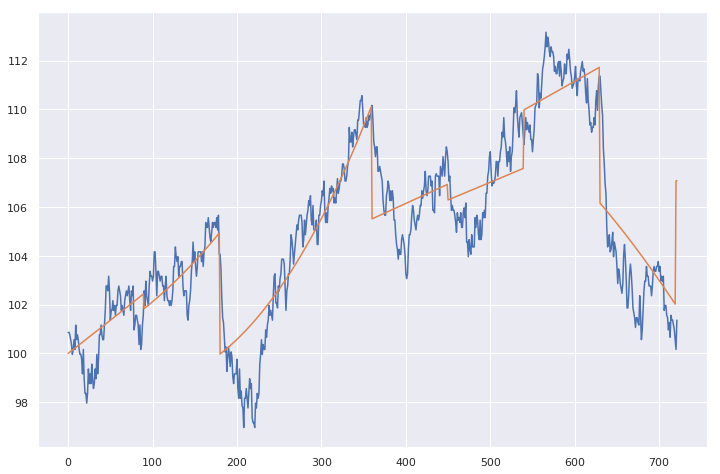

In [20]:
def plot(ticker):
    sns.set(rc={'figure.figsize':(12.0,8.0)})
    h = market.history_for(ticker)
    s = market.stocks[ticker]
    p_open, p_close, p_high, p_low = np.transpose(h)
    t = np.array(range(len(p_open)))
    sns.lineplot(t, p_open);
    sns.lineplot(t, [s.psi(tt) for tt in t]);
plot('AAPL')

### Log Returns

In [21]:
h = {ticker: np.array(market.history_for(ticker))[:,0] 
     for ticker in market.prices}
h['AAPL'].shape

(722,)

In [22]:
lr = {}
for ticker in market.prices:
    l = np.log(h[ticker])
    lr[ticker] = l[1:] - l[:-1]

In [23]:
from statsutils import MovingStats

widthes = [10, 20, 30]
avgs = {}
for ticker in market.prices:
    avgs[ticker] = {w: [] for w in widthes}
    ms = {w: MovingStats(w) for w in widthes}
    for v in lr[ticker]:
        for w in widthes:
            ms[w].push(v)
            avgs[ticker][w].append(ms[w].stats()[0])


#### Moving Averages of Log Returns

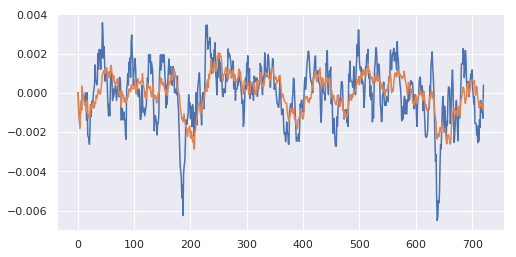

In [24]:
ticker = 'AAPL'

sns.set(rc={'figure.figsize':(8.0,4.0)})
#sns.lineplot(range(len(lr[ticker])), lr[ticker])
for w in [10, 30]:
    sns.lineplot(range(len(avgs[ticker][w])), avgs[ticker][w])

A simple sanity check: The exponential of the sum of all log returns is the total return.

In [25]:
V0 = market.history_for(ticker)[0][2]
print( "Accumulated returns  : %s" % 
      float(V0*np.exp(np.sum(lr[ticker]))))
print( "Value after two years: %s" % 
      market.history_for(ticker)[-1][0])

Accumulated returns  : 101.36299999999997
Value after two years: 101.363


In [26]:
len(avgs['AAPL'][30])

721

---
## Portfolio Weights

In [27]:
def performance(investor):
    initial_wealth = np.sum([
        500 * market.history_for(ticker)[0][2]
        for ticker in investor.portfolio
    ]) + 500

    total_wealth = np.sum([
        portfolio[ticker] * market.price_for(ticker)[0]
        for ticker in investor.portfolio
    ]) + investor.cash

    return initial_wealth, total_wealth

print(performance(investors[1]))
print(performance(investors[3]))

(224555.0, 328614.7000000003)
(224555.0, 301662.5499999998)


In [28]:
inv = investors[3]
inv.portfolio, inv.cash, performance(inv)

({'AAPL': 1420, 'MSFT': 230, 'TSLA': 730},
 21634.72999999982,
 (224555.0, 301662.5499999998))

In [30]:
total_wealth = performance(inv)[1]
portfolio = inv.portfolio
weights = {}
for ticker in portfolio:
    price = market.price_for(ticker)[0]
    position = portfolio[ticker]
    weight = position * price / total_wealth
    weights[ticker] = weight
weights['cash'] = inv.cash / total_wealth
weights, np.sum(list(weights.values()))

({'AAPL': 0.4431597919091392,
  'MSFT': 0.14307471659381052,
  'TSLA': 0.34767638999624284,
  'cash': 0.06608910150080748},
 1.0)

---
## ANN-Based Trader Model

In [31]:
N_LSTM_NEURONS = 128
N_STOCKS = len(portfolio)
BATCH_SIZE = 128
N_STEPS = 20                  # history length for the LSTM
N_OUT = N_STOCKS + 1          # stocks and cash
# current log returns, positions' weights, cash weight
N_FEATURES = N_STOCKS * 2 + 1

In [32]:
from models import LSTM_TraderModel

In [33]:
lstm_model = LSTM_TraderModel(
    n_neurons=N_LSTM_NEURONS, 
    n_steps=N_STEPS,
    n_features=N_FEATURES,
    n_out=N_OUT)

x = np.random.random(
    [BATCH_SIZE, N_STEPS, N_FEATURES]).astype(np.float32)

y = lstm_model(x) # initialize the model
test_portfolio = lstm_model.portfolio(x)
lstm_model.summary()

Model: "lstm__trader_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  69632     
_________________________________________________________________
dense (Dense)                multiple                  516       
Total params: 70,148
Trainable params: 70,148
Non-trainable params: 0
_________________________________________________________________


In [34]:
test_portfolio[0]

<tf.Tensor: id=306, shape=(4,), dtype=float32, numpy=array([0.28884757, 0.22801556, 0.22368401, 0.25945288], dtype=float32)>

Sanity check: Are the portfolio outputs normalized?

In [35]:
tf.reduce_sum(test_portfolio[0]).numpy()

1.0

---
## Smart Investor

In [36]:
class SmartInvestor():
    def __init__(self, model, market, cash, portfolio):
        """
        Parameters: 
        market: the market model
        cash: the initial cash amount
        portfolio: initial map of stock tickers and weights
        """
        self.model = model
        self.market = market
        self.cash = cash
        self.portfolio = portfolio
        
    def total_wealth(self):
        value = self.cash
        for asset in self.portfolio:
            size = self.portfolio[asset]
            value += size * self.market.price_for(asset)[0]
        return value

In [37]:
portfolio={'AAPL': 0, 'TSLA': 0, 'MSFT': 0}

wb = SmartInvestor(model     = lstm_model, 
                   market    = market, 
                   cash      = 1e5, 
                   portfolio = portfolio)